<a href="https://colab.research.google.com/github/Rajat-Kumar-Pandey/MACHINE-LEARNING/blob/main/sleep_detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Splitting datasets to train test and validation**


In [1]:
import os
import shutil
import random

# Define paths
base_dir = "/content/drive/MyDrive/datasets"
categories = ["openeyes", "closeeyes"]
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

# Split ratios
train_ratio = 0.7
val_ratio = 0.2
test_ratio = 0.1

# Create directories if not exist
for split in [train_dir, val_dir, test_dir]:
    for category in categories:
        os.makedirs(os.path.join(split, category), exist_ok=True)

# Function to split dataset
def split_data(category_path, train_dest, val_dest, test_dest):
    files = os.listdir(category_path)
    random.shuffle(files)
    total_files = len(files)

    # Calculate split indices
    train_end = int(total_files * train_ratio)
    val_end = train_end + int(total_files * val_ratio)

    train_files = files[:train_end]
    val_files = files[train_end:val_end]
    test_files = files[val_end:]

    # Move files to respective directories
    for file in train_files:
        shutil.move(os.path.join(category_path, file), train_dest)
    for file in val_files:
        shutil.move(os.path.join(category_path, file), val_dest)
    for file in test_files:
        shutil.move(os.path.join(category_path, file), test_dest)

# Iterate over categories and split data
for category in categories:
    category_path = os.path.join(base_dir, category)
    train_dest = os.path.join(train_dir, category)
    val_dest = os.path.join(val_dir, category)
    test_dest = os.path.join(test_dir, category)

    split_data(category_path, train_dest, val_dest, test_dest)

print("Dataset successfully split into train, val, and test sets!")


Dataset successfully split into train, val, and test sets!


**Import libraries**

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths for the train, validation, and test datasets
train_dir = "/content/drive/MyDrive/datasets/train"
val_dir = "/content/drive/MyDrive/datasets/val"
test_dir = "/content/drive/MyDrive/datasets/test"

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Randomly rotate images by 20 degrees
    width_shift_range=0.2,  # Randomly shift images horizontally by 20%
    height_shift_range=0.2,  # Randomly shift images vertically by 20%
    shear_range=0.2,  # Shear the image
    zoom_range=0.2,  # Randomly zoom into images
    horizontal_flip=True,  # Flip images horizontally
    fill_mode="nearest"  # Fill pixels after transformation
)

# For validation and test datasets, only normalization
val_test_datagen = ImageDataGenerator(rescale=1.0/255)

# Generate augmented training data
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize all images to 150x150
    batch_size=32,
    class_mode="binary"  # Use 'categorical' for multi-class classification
)

# Generate validation and test data
val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary"
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode="binary"
)


Found 770 images belonging to 2 classes.
Found 220 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


**Check the classes and batch shapes:**

In [4]:
# Check class labels
print("Class indices:", train_generator.class_indices)

# Fetch a single batch of images and labels
images, labels = next(train_generator)

# Print shapes
print("Batch shape (images):", images.shape)
print("Batch shape (labels):", labels.shape)


Class indices: {'closeeyes': 0, 'openeyes': 1}
Batch shape (images): (32, 150, 150, 3)
Batch shape (labels): (32,)


**Visualize a few augmented images**

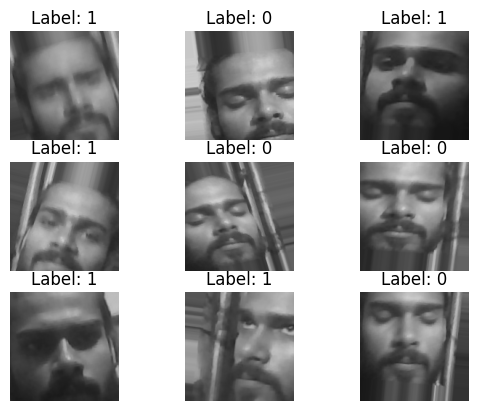

In [5]:
import matplotlib.pyplot as plt

# Plot a few images with their labels
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i])
    plt.title(f"Label: {int(labels[i])}")  # For binary classification
    plt.axis("off")
plt.show()


In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers.schedules import ExponentialDecay

model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    BatchNormalization(),  # Normalize activations
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(256, (3, 3), activation="relu"),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    # Global Average Pooling to reduce parameters
    GlobalAveragePooling2D(),

    Dense(128, activation="relu"),
    Dropout(0.5),  # Regularization to avoid overfitting

    Dense(1, activation="sigmoid")  # Sigmoid for binary classification
])

# Define exponential decay learning rate
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,  # Starting learning rate
    decay_steps=100000,           # How often to apply the decay
    decay_rate=0.96,              # The rate at which the learning rate decays
    staircase=True                # If True, decay the learning rate in discrete steps
)


# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),  # Lower learning rate for better convergence
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 148, 148, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 72, 72, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 34, 34, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 15, 15, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 15, 15, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 423,361 (1.61 MB)

 Trainable params: 422,401 (1.61 MB)

 Non-trainable params: 960 (3.75 KB)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,  # You can adjust the number of epochs
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print("Test accuracy:", test_accuracy)
print("Test loss:", test_loss)


Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6351 - loss: 0.6357 - val_accuracy: 0.5521 - val_loss: 0.6795
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - accuracy: 0.6875 - loss: 0.6138 - val_accuracy: 0.5000 - val_loss: 0.6953
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 79s 3s/step - accuracy: 0.6758 - loss: 0.6316 - val_accuracy: 0.5521 - val_loss: 1.0897
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.9062 - loss: 0.3457 - val_accuracy: 0.5000 - val_loss: 1.2141
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 491ms/step - accuracy: 0.5352 - loss: 0.6880
Test accuracy: 0.53125
Test loss: 0.6881335377693176
